In [ ]:
ImageFolder = '/camp/home/benzind/home/users/benzind/Data/Optopaper/oSHH4/Day3' #Change for real image folder

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
import glob

from aicsimageio import AICSImage as iio
from tifffile import imwrite
from tifffile import imread

import cv2 as cv
import statsmodels.api as sm
from skimage import data, restoration, util


In [48]:
import pickle

import matplotlib.pyplot as plt
plt.rcParams["font.family"] = "sans-serif"

plt.rcParams['font.sans-serif'] = ['Tahoma', 'DejaVu Sans',
                               'Lucida Grande', 'Verdana']
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)


In [55]:
def findPattern(im):
    _, thresh = cv.threshold(im[0,:], 0, 255, cv.THRESH_BINARY + cv.THRESH_OTSU)
    thresh = thresh.astype(np.uint8)
    kernel = np.ones((20,20),np.uint8)
    close = cv.morphologyEx(thresh, cv.MORPH_CLOSE, kernel)
    contours, _ = cv.findContours(close, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)
    largest_contour = max(contours, key=cv.contourArea)
    epsilon = 0.05 * cv.arcLength(largest_contour, True)
    approx_rect = cv.approxPolyDP(largest_contour, epsilon, True)
    x, y, w, h = cv.boundingRect(approx_rect)
    return im[:,y:y+h, x:x+w]

def is_outlier(points, thresh):
    if len(points.shape) == 1:
        points = points[:,None]
    median = np.median(points)
    diff = np.absolute(points - median)
    med_abs_deviation = np.median(diff)

    modified_z_score = 0.6745 * diff / med_abs_deviation

    return abs(modified_z_score) > thresh

def AlignCurves(curves, half_max_x_positions):

    # Find the minimum length to the left and right of the half-maximal value among all curves
    min_left = 480#min([half_max_x for half_max_x in half_max_x_positions])
    min_right = 150 #min([len(curve) - half_max_x for curve, half_max_x in zip(curves, half_max_x_positions)])

    # Initialize a list to store the aligned and cropped curves
    aligned_curves = []

    for curve, half_max_x in zip(curves, half_max_x_positions):
        # Calculate the start and end indices for slicing
        start_index = max(half_max_x - min_left, 0)
        end_index = min(half_max_x + min_right, len(curve))
        
        # Slice the curve around the half-maximal x-value
        aligned_curve = curve[start_index:end_index]
        
        # Store the aligned and cropped curve
        aligned_curves.append(aligned_curve)
    return aligned_curves

def Image2Profile(image, CropLenght, outlierThresh, SmoothFrac):
    image=image[:,CropLenght:-CropLenght,0:-CropLenght]
    curves = []
    for i in range(image.shape[0]):
        #normalize to cell count based on SOX2-staining?
        #data = data / image[0,:,:]
        #Try rollingball substraction
        background = 0# restoration.rolling_ball(image[i,:,:], radius=25)
        data = image[i,:,:]-background
        data = data - data.min()

        
        outliers = [is_outlier(data,outlierThresh)] 
        masked_data = np.ma.masked_array(data, mask=outliers)
        averages = np.ma.mean(masked_data, axis=0)

        x_values = np.arange(len(averages))
        lowess = sm.nonparametric.lowess
        smoothed = lowess(averages, x_values, frac=SmoothFrac)
        smoothed_averages = smoothed[:, 1]
        baseline = np.min(smoothed_averages)
        max_value = np.max(smoothed_averages)
        smoothed_averages = (smoothed_averages - baseline) / (max_value-baseline)

        curves.append(smoothed_averages)
    return curves

/camp/home/benzind/home/users/benzind/Data/Optopaper/oSHH4/Day3
[1490, 1483, 490, 1575, 577, 1535, 1494, 1532, 1599, 547, 1465, 1451, 589, 506, 1532, 1500, 1482, 531]


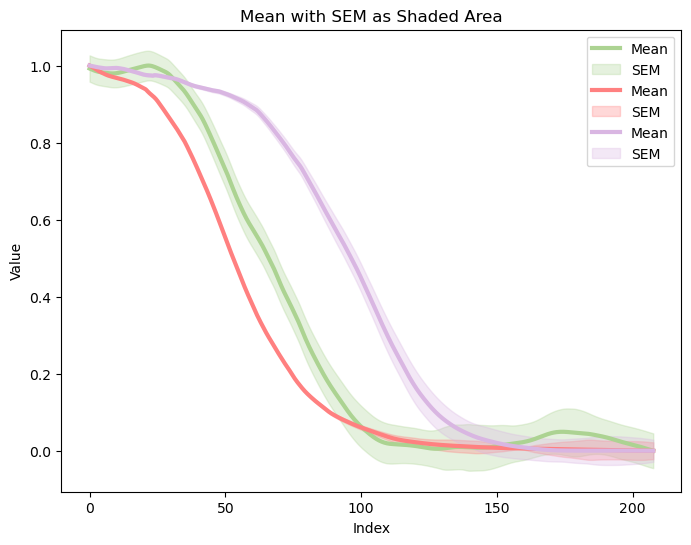

In [56]:
folder=ImageFolder
print(folder)
start=0
ImagePaths = glob.glob(folder+'/*Repeat*Stain1*.tif')
curves = []
average_curves = []
sem_curves = []
for ImagePath in ImagePaths:
    image = imread(ImagePath)
    image = image[:,:,start:]
 #   image = image / image[0,:,:]
    curves.append(Image2Profile(image, 100, 100, 0.075))

RFP = [lst[2] for lst in curves if len(lst) > 1]
Hmax = []
for p in RFP:
    Hmax.append(np.argmax(p >= 0.5))
print(Hmax)


domains = len(curves[0])
plt.figure(figsize=(8, 6))
colors = ['black','#acd392','#ff8080','#d9b6e2']

for domain in range(1,domains):
    stacked_arrays = np.stack(AlignCurves([lst[domain] for lst in curves if len(lst) > 1],Hmax))
    
    means = np.flip(np.mean(stacked_arrays, axis=0))
    x_values = np.arange(len(means)) * 0.33 #Rescaling pixels to uM

    # Plotting
    
    baseline = np.min(means)
    max_value = np.max(means)
    means = (means - baseline) / (max_value-baseline)
    average_curves.append(means)
    
    std_dev = np.std(stacked_arrays, axis=0, ddof=1) / (max_value-baseline)  # adjusted for rescaling of means for plotting
    sem = std_dev / np.sqrt(stacked_arrays.shape[0])
    sem_curves.append(sem)

    # Mean as a solid curve
    plt.plot(x_values[0:], means[0:], label='Mean', linestyle='-', color=colors[domain],linewidth=3.0)

    # SEM as a shaded area
    plt.fill_between(x_values, means - sem, means + sem, color=colors[domain], alpha=0.3, label='SEM')

# Adding labels and legend
plt.xlabel('Index')
plt.ylabel('Value')
plt.title('Mean with SEM as Shaded Area')
plt.legend()

# Show the plot
plt.show()

/camp/home/benzind/home/users/benzind/Data/Optopaper/oSHH4/Day3
[720, 742, 856, 819, 817, 835, 771, 781, 756, 782, 780, 845, 807, 800, 783, 709, 787, 803]


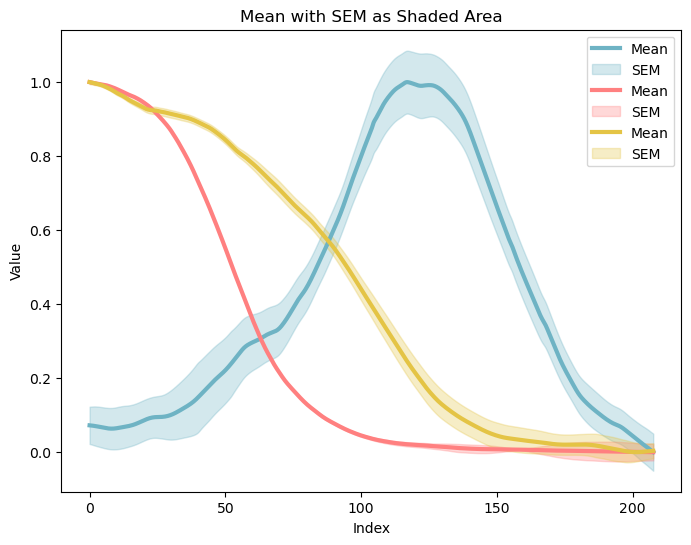

In [57]:
folder=ImageFolder
print(folder)
ImagePaths = glob.glob(folder+'/*Repeat*Stain2*.tif')
curves = []
start=750

for ImagePath in ImagePaths:
    image = imread(ImagePath)
    image = image[:,:,start:]
 #   image = image / image[0,:,:]
    curves.append(Image2Profile(image, 100, 100, 0.075))

RFP = [lst[2] for lst in curves if len(lst) > 1]
Hmax = []
for p in RFP:
    Hmax.append(np.argmax(p >= 0.5))
print(Hmax)


domains = len(curves[0])
plt.figure(figsize=(8, 6))
colors = ['black','#6eb3c4ff','#ff8080','#e4c445ff']

for domain in range(1,domains):
    stacked_arrays = np.stack(AlignCurves([lst[domain] for lst in curves if len(lst) > 1],Hmax))
    means = np.flip(np.mean(stacked_arrays, axis=0))

    x_values = np.arange(len(means)) * 0.33

    # Plotting
    
    baseline = np.min(means)
    max_value = np.max(means)
    means = (means - baseline) / (max_value-baseline)
    average_curves.append(means)
    
    std_dev = np.std(stacked_arrays, axis=0, ddof=1) / (max_value-baseline)  # adjusted for rescaling of means for plotting
    sem = std_dev / np.sqrt(stacked_arrays.shape[0])
    sem_curves.append(sem)

    # Mean as a solid curve
    plt.plot(x_values[0:], means[0:], label='Mean', linestyle='-', color=colors[domain],linewidth=3.0)

    # SEM as a shaded area
    plt.fill_between(x_values, means - sem, means + sem, color=colors[domain], alpha=0.3, label='SEM')
# Adding labels and legend
plt.xlabel('Index')
plt.ylabel('Value')
plt.title('Mean with SEM as Shaded Area')
plt.legend()

# Show the plot
plt.show()

In [58]:
#remove first RFP curve
del(average_curves[1])
del(sem_curves[1])


In [59]:
domain_start = []
for curve in average_curves:
    domain_start.append(np.argmax(np.flip(curve) >= 0.2))
domain_start.sort()

domain_sizes = []

for i in range(len(domain_start)-1):
    domain_sizes.append((domain_start[i+1]-domain_start[i])*0.33)
print(domain_sizes)
print(sum(domain_sizes)) 

[55.440000000000005, 4.29, 31.020000000000003, 14.520000000000001]
105.27


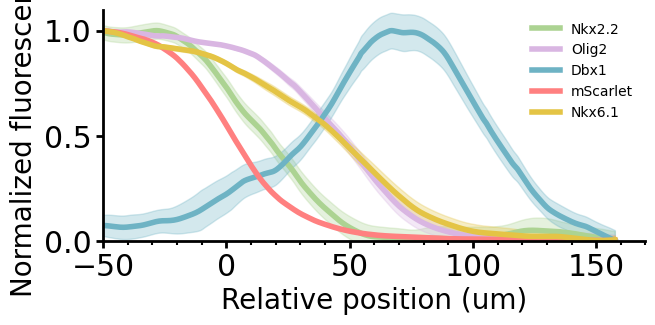

In [60]:
colors = ['#acd392','#d9b6e2','#6eb3c4ff','#ff8080','#e4c445ff']
labels = ['Nkx2.2','Olig2','Dbx1','mScarlet','Nkx6.1']

f, ax = plt.subplots(1,figsize=(7, 3))


for curve, sem,color,label in zip(average_curves, sem_curves,colors,labels):    
    
    x_values = np.arange(len(curve)) * 0.33 - 50 #Rescaling pixels to uM

    # Mean as a solid curve
    ax.plot(x_values[0:], curve, label=label, linestyle='-', color=color,linewidth=4.0)

    # SEM as a shaded area
    ax.fill_between(x_values, curve- sem, curve + sem, color=color, alpha=0.3)

# Adding labels and legend
ax.spines['bottom'].set_linewidth(2)
ax.spines['left'].set_linewidth(2)
ax.tick_params(width=2)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)


ax.set(xlabel='Relative position (um)', ylabel='Normalized fluorescence')
ax.xaxis.label.set_size(20)
ax.yaxis.label.set_size(20)

ax.tick_params(axis='both', which='major', labelsize=21.5,length=5)
ax.xaxis.set_minor_locator(AutoMinorLocator())
ax.tick_params(which='minor', width=1.5,length=3)

#plt.title('Mean with SEM as Shaded Area')
ax.legend(frameon=False, fontsize = 10)
ax.set_xlim(-50, 170) 
ax.set_ylim(0, 1.1) 


# Show the plot
plt.show(f)

f.savefig("oSHH4_quant.svg", bbox_inches=0, transparent=True)
